In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib as mlp
import matplotlib.pyplot as plt
import sklearn.linear_model as skm
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import RepeatedStratifiedKFold,GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN

Define the notation:

-$C$: set of the classes

-$Y$: array of target values

-$Y_c$: array of the classes assigned to each entry in $Y$

$$
\forall i \in \{0, 1, 2, \ldots, \text{{len(Y)}}-1\}, Y_c[i] \in C
$$
and, if $Y_c[i] = n$, it means that $Y[i]$ belongs to class $n$

First, we read the training and test set.

In [2]:
X_test=pd.read_csv("sets/X_test.csv")
X_train=pd.read_csv("sets/X_train.csv")
y_test=pd.read_csv("sets/y_test.csv")['score']
y_train=pd.read_csv("sets/y_train.csv")['score']
print(X_test.columns)

Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'num_of_prev_attempts', 'studied_credits', 'disability',
       'date_registration', 'forumng_clicks', 'homepage_clicks',
       'oucontent_clicks', 'resource_clicks', 'subpage_clicks', 'url_clicks',
       'dataplus_clicks', 'glossary_clicks', 'oucollaborate_clicks',
       'quiz_clicks', 'ouelluminate_clicks', 'sharedsubpage_clicks',
       'questionnaire_clicks', 'page_clicks', 'externalquiz_clicks',
       'ouwiki_clicks', 'dualpane_clicks', 'folder_clicks',
       'repeatactivity_clicks', 'htmlactivity_clicks', 'assessment_type',
       'weight', 'submission_delay'],
      dtype='object')


We choose the amount of classes we want to divide the $Y$ into and build our $Y_c$ based on the range in which each value of $Y$ falls into.

$$
Y_c[i]=\left\lceil\frac{Y[i]-\min{Y}}{\frac{\max{Y}-\min{Y}}{\lvert C\rvert}}\right\rceil
$$

In [3]:
classes=5

def classesAssignment(nClasses, set, maximum, minimum):
    """
    Modifies the set in input such that values will be rounded off to the corresponding class.
     Args:
     nClasses: the expected quantity of values
     set: the set that has to be modified
     maximum: the maximum possible value in the set
     minimum: the minimum possible value in the set
    """

    retSet=np.ceil((set-minimum)/((maximum-minimum)/nClasses))
    
    for i in range(len(retSet)) :
        if retSet[i]==0 :
            retSet[i]=1

    return retSet


maximum=max(y_test.max(),y_train.max())
minimum=min(y_test.min(),y_train.min())

y_test1=classesAssignment(classes,y_test,maximum,minimum)
y_train1=classesAssignment(classes,y_train,maximum,minimum)

Now we set up the model.

In [4]:
lrm = skm.LogisticRegression(max_iter=10000,random_state=2)

print(X_train.columns)

Index(['gender', 'region', 'highest_education', 'imd_band', 'age_band',
       'num_of_prev_attempts', 'studied_credits', 'disability',
       'date_registration', 'forumng_clicks', 'homepage_clicks',
       'oucontent_clicks', 'resource_clicks', 'subpage_clicks', 'url_clicks',
       'dataplus_clicks', 'glossary_clicks', 'oucollaborate_clicks',
       'quiz_clicks', 'ouelluminate_clicks', 'sharedsubpage_clicks',
       'questionnaire_clicks', 'page_clicks', 'externalquiz_clicks',
       'ouwiki_clicks', 'dualpane_clicks', 'folder_clicks',
       'repeatactivity_clicks', 'htmlactivity_clicks', 'assessment_type',
       'weight', 'submission_delay'],
      dtype='object')


And train it.

In [5]:
lrm.fit(X_train,y_train1)

LogisticRegression(max_iter=10000, random_state=2)

We can then check the accuracy, the recall, and all the metrics available in "classification_report".

In [6]:
preds=lrm.predict(X_test)

check=preds==y_test1

accuracy=(sum(preds==y_test1))/len(preds)
print("Accuracy:", accuracy)
print(classification_report(y_test1, preds))

preds_train=lrm.predict(X_train)
check=preds_train==y_train1
accuracy = accuracy_score(y_train1, preds_train)
print("Accuracy training:", accuracy)
print(classification_report(y_train1, preds_train))

Accuracy: 0.5048962604810576
              precision    recall  f1-score   support

         1.0       1.00      0.00      0.00       506
         2.0       0.00      0.00      0.00      1228
         3.0       0.32      0.02      0.04      4477
         4.0       0.45      0.56      0.50     12358
         5.0       0.56      0.67      0.61     14109

    accuracy                           0.50     32678
   macro avg       0.47      0.25      0.23     32678
weighted avg       0.47      0.50      0.46     32678

Accuracy training: 0.5032935758057976
              precision    recall  f1-score   support

         1.0       0.20      0.00      0.00      2033
         2.0       0.03      0.00      0.00      5107
         3.0       0.35      0.02      0.04     18013
         4.0       0.45      0.56      0.50     49182
         5.0       0.56      0.67      0.61     56374

    accuracy                           0.50    130709
   macro avg       0.32      0.25      0.23    130709
weighted a

And we can also check out the confusion matrix and most influential features

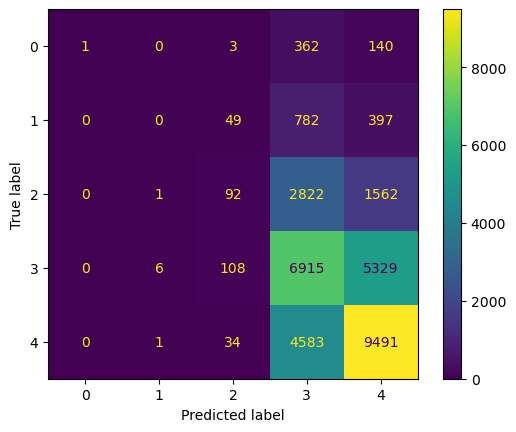

Selected Features: Index(['forumng_clicks', 'dataplus_clicks', 'questionnaire_clicks', 'weight',
       'submission_delay'],
      dtype='object')


In [7]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test1, preds))
disp.plot()
plt.show()
#coefficients=lrm.coef_
sfm = SelectFromModel(lrm, threshold=1e-0)
sfm.fit(X_train, y_train1)

# Selected features
selected_features = X_train.columns[sfm.get_support()]

# Display selected features
print("Selected Features:", selected_features)

For practical reasons, we merge all these steps in a single function

In [8]:
def myLogReg(X_train,y_train,X_test,y_test):
    '''
    Executes the Logistic Regression on the sets in input
    '''

    lrm = skm.LogisticRegression(max_iter=10000,random_state=2)
    lrm.fit(X_train,y_train)

    preds=lrm.predict(X_test)

    print("Classification report for the test set")
    print(classification_report(y_test, preds))
    print("Classification report for the train set")
    print(classification_report(y_train, lrm.predict(X_train)))

    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, preds))
    disp.plot()
    plt.show()


Let's try another approach: divide the $Y$ in equally numbered classes.

Let $Y_{sort}$ be the sorted version of $Y$, and let $Y_{index}$ be the array of the assigned position for each value in $Y$ in its sorted version $Y_{sort}$:
$$
(Y[i]=v \land Y_{index}[i]= j ) \Rightarrow Y_{sort}[j]=v
$$
Then, we define $Y_c$ as follows:
$$
Y_c[i]=\left\lceil \frac{Y_{index}[i]}{\frac{len(Y)}{\lvert C \rvert}} \right\rceil
$$



In [9]:

def fairClassesAssignment(nClasses, set, maximum, minimum):
    """
    Modifies the set in input such that values will be rounded off and divided in classes in a more
    distributed (and approximately fair) fashion.
     Args:
     nClasses: the expected quantity of values
     set: the set that has to be modified
     maximum: the maximum possible value in the set
     minimum: the minimum possible value in the set
    """
    set += np.abs(minimum)
    retSet = np.zeros(len(set))

    setIndex = sorted(list(zip(set,range(len(set)))))

    binSize=len(set)/nClasses
    
    for i in range(len(set)):
        retSet[setIndex[i][1]]=min((i//binSize)+1,nClasses)

    return retSet


maximum=max(y_test.max(),y_train.max())
minimum=min(y_test.min(),y_train.min())

y_test2=fairClassesAssignment(classes,y_test,maximum,minimum)
y_train2=fairClassesAssignment(classes,y_train,maximum,minimum)


Now that classes are balanced, let's try again logistic regression.

Classification report for the test set
              precision    recall  f1-score   support

         1.0       0.34      0.48      0.40      6536
         2.0       0.28      0.24      0.26      6536
         3.0       0.25      0.07      0.10      6535
         4.0       0.34      0.36      0.35      6536
         5.0       0.40      0.57      0.47      6535

    accuracy                           0.34     32678
   macro avg       0.32      0.34      0.32     32678
weighted avg       0.32      0.34      0.32     32678

Classification report for the train set
              precision    recall  f1-score   support

         1.0       0.35      0.48      0.41     26142
         2.0       0.28      0.24      0.26     26142
         3.0       0.25      0.06      0.10     26142
         4.0       0.33      0.35      0.34     26142
         5.0       0.39      0.57      0.46     26141

    accuracy                           0.34    130709
   macro avg       0.32      0.34      0.31    13070

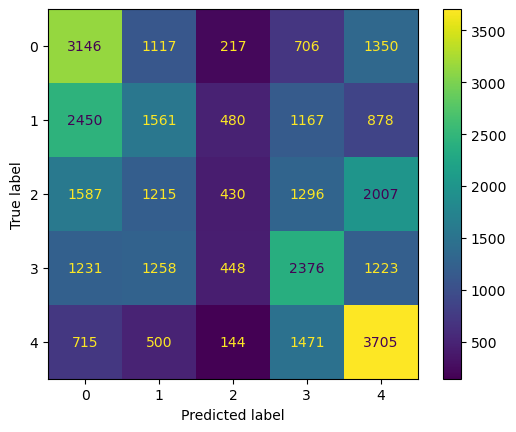

In [10]:
myLogReg(X_train,y_train2,X_test,y_test2)

Let's try another approach: divide $Y$ in classes such that the sum of the values in each class is (approximately) the same.
$$
Y_c[i]=\left\lceil \frac{\sum\limits_{j\leq i} Y_{sort}[j]}{\frac{\sum\limits_j Y[j]}{\lvert C \rvert}} \right\rceil
$$

In [11]:
def fairGradeClassesAssignment(nClasses, set, maximum, minimum):
    """
    Modifies the set in input such that values will be rounded off and divided in classes in a more
    distributed (and approximately fair) fashion on the basis of the assigned grade.
     Args:
     nClasses: the expected quantity of values
     set: the set that has to be modified
     maximum: the maximum possible value in the set
     minimum: the minimum possible value in the set
    """

    set += np.abs(minimum)
    sumGradesPerClass=sum(set)/nClasses
    retSet = np.zeros(len(set))

    setIndex = sorted(list(zip(set,range(len(set)))))
    curClass=1
    gradeCheck=0

    for i in range(len(set)):
        retSet[setIndex[i][1]]=min(curClass,nClasses)
        gradeCheck+=setIndex[i][0]
        if(gradeCheck>=sumGradesPerClass):
            gradeCheck=0
            curClass+=1
        #if(setIndex[i][0]<40):
        #    retSet[setIndex[i][1]]=1
        #else:
        #    retSet[setIndex[i][1]]=2

    return retSet


maximum=max(y_test.max(),y_train.max())
minimum=min(y_test.min(),y_train.min())

y_test3=fairGradeClassesAssignment(classes,y_test,maximum,minimum)
y_train3=fairGradeClassesAssignment(classes,y_train,maximum,minimum)

Classification report for the test set
              precision    recall  f1-score   support

         1.0       0.39      0.75      0.52      9429
         2.0       0.26      0.07      0.11      6697
         3.0       0.23      0.05      0.09      6048
         4.0       0.36      0.33      0.34      5503
         5.0       0.45      0.58      0.51      5001

    accuracy                           0.38     32678
   macro avg       0.34      0.36      0.31     32678
weighted avg       0.34      0.38      0.32     32678

Classification report for the train set
              precision    recall  f1-score   support

         1.0       0.40      0.75      0.52     37801
         2.0       0.26      0.07      0.11     26790
         3.0       0.23      0.05      0.09     24167
         4.0       0.36      0.33      0.34     21973
         5.0       0.44      0.59      0.51     19978

    accuracy                           0.39    130709
   macro avg       0.34      0.36      0.32    13070

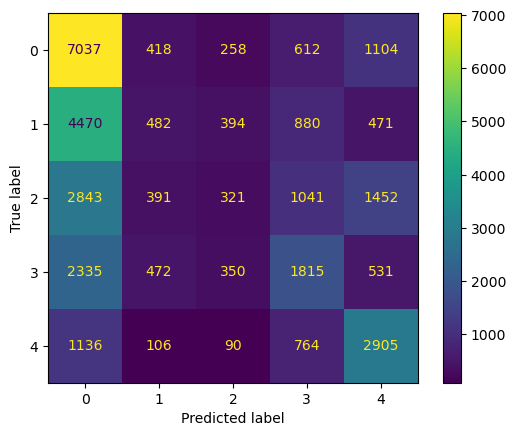

In [12]:
myLogReg(X_train,y_train3,X_test,y_test3)

Last of all, let's simply divide $Y$ in classes based on the semantic meaning of the value.
Since the values in $Y$ represent a grade assigned to an assessment/exam, and a grade under 40 is interpreted as fail, let's just divide $Y$ in two classes representing "fail" and "success".

$$
Y_c[i]= \min{[1,\left\lfloor \frac{Y[i]}{40} \right\rfloor ]} +1
$$

In [13]:
def failSuccClassesAssignment(set):

    retSet = np.zeros(len(set))

    for i in range(len(set)):
        if(set[i]<40):
            retSet[i]=1
        else:
            retSet[i]=2

    return retSet


y_test4=failSuccClassesAssignment(y_test)
y_train4=failSuccClassesAssignment(y_train)

Classification report for the test set
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      1353
         2.0       0.96      1.00      0.98     31325

    accuracy                           0.96     32678
   macro avg       0.48      0.50      0.49     32678
weighted avg       0.92      0.96      0.94     32678

Classification report for the train set
              precision    recall  f1-score   support

         1.0       0.05      0.00      0.00      5648
         2.0       0.96      1.00      0.98    125061

    accuracy                           0.96    130709
   macro avg       0.50      0.50      0.49    130709
weighted avg       0.92      0.96      0.94    130709



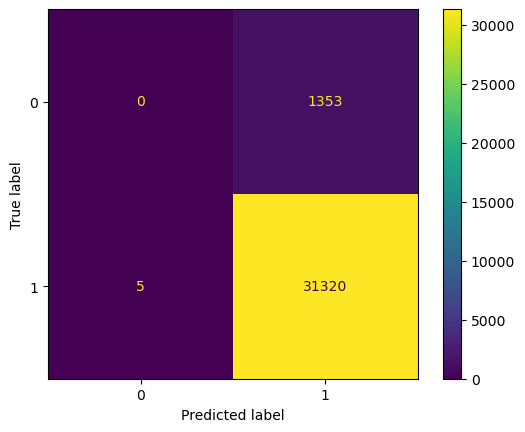

In [14]:
myLogReg(X_train,y_train4,X_test,y_test4)

LET'S TRY OVERSAMPLING TO FIT REPRESENTATION ISSUE

Classification report for the test set
              precision    recall  f1-score   support

         1.0       0.03      0.54      0.06       506
         2.0       0.09      0.45      0.16      1228
         3.0       0.18      0.13      0.15      4477
         4.0       0.46      0.15      0.23     12358
         5.0       0.61      0.48      0.54     14109

    accuracy                           0.31     32678
   macro avg       0.27      0.35      0.23     32678
weighted avg       0.46      0.31      0.35     32678

Classification report for the train set
              precision    recall  f1-score   support

         1.0       0.33      0.52      0.40     56374
         2.0       0.32      0.43      0.37     56374
         3.0       0.26      0.13      0.18     56374
         4.0       0.33      0.15      0.21     56374
         5.0       0.44      0.49      0.46     56374

    accuracy                           0.34    281870
   macro avg       0.33      0.34      0.32    28187

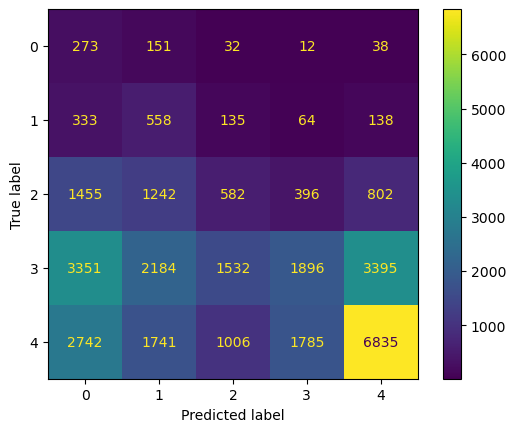

In [15]:
ros = RandomOverSampler(random_state=0)
X_resampled1, y_resampled1 = ros.fit_resample(X_train, y_train1)

myLogReg(X_resampled1, y_resampled1,X_test,y_test1)


Classification report for the test set
              precision    recall  f1-score   support

         1.0       0.34      0.48      0.40      6536
         2.0       0.28      0.24      0.26      6536
         3.0       0.25      0.07      0.10      6535
         4.0       0.34      0.36      0.35      6536
         5.0       0.40      0.57      0.47      6535

    accuracy                           0.34     32678
   macro avg       0.32      0.34      0.32     32678
weighted avg       0.32      0.34      0.32     32678

Classification report for the train set
              precision    recall  f1-score   support

         1.0       0.35      0.48      0.41     26142
         2.0       0.28      0.24      0.26     26142
         3.0       0.25      0.06      0.10     26142
         4.0       0.33      0.35      0.34     26142
         5.0       0.39      0.57      0.46     26142

    accuracy                           0.34    130710
   macro avg       0.32      0.34      0.31    13071

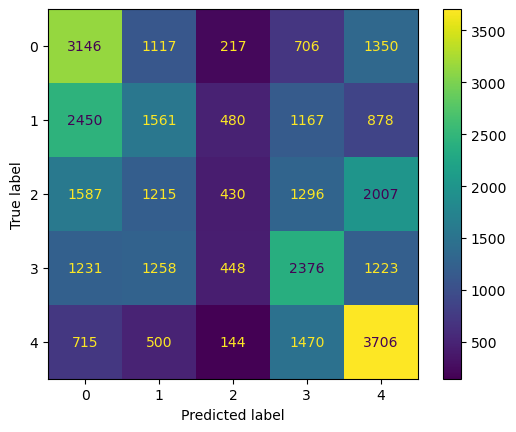

In [16]:
ros = RandomOverSampler(random_state=0)
X_resampled2, y_resampled2 = ros.fit_resample(X_train, y_train2)

myLogReg(X_resampled2, y_resampled2,X_test,y_test2)

Classification report for the test set
              precision    recall  f1-score   support

         1.0       0.46      0.52      0.49      9429
         2.0       0.27      0.17      0.21      6697
         3.0       0.21      0.08      0.11      6048
         4.0       0.33      0.42      0.37      5503
         5.0       0.39      0.68      0.49      5001

    accuracy                           0.37     32678
   macro avg       0.33      0.37      0.33     32678
weighted avg       0.34      0.37      0.34     32678

Classification report for the train set
              precision    recall  f1-score   support

         1.0       0.36      0.52      0.43     37801
         2.0       0.28      0.17      0.21     37801
         3.0       0.24      0.08      0.12     37801
         4.0       0.37      0.42      0.40     37801
         5.0       0.46      0.68      0.55     37801

    accuracy                           0.38    189005
   macro avg       0.34      0.38      0.34    18900

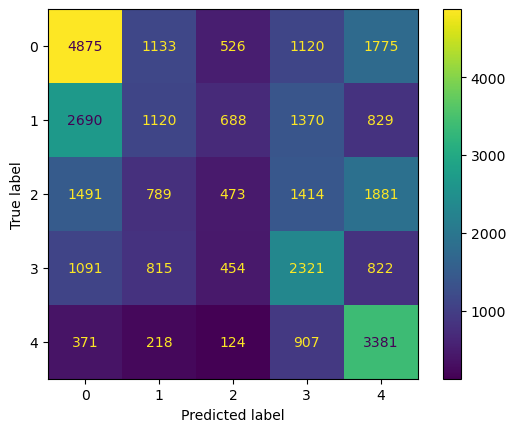

In [17]:
ros = RandomOverSampler(random_state=0)
X_resampled3, y_resampled3 = ros.fit_resample(X_train, y_train3)

myLogReg(X_resampled3, y_resampled3,X_test,y_test3)

Classification report for the test set
              precision    recall  f1-score   support

         1.0       0.08      0.79      0.14      1353
         2.0       0.98      0.58      0.73     31325

    accuracy                           0.59     32678
   macro avg       0.53      0.69      0.43     32678
weighted avg       0.95      0.59      0.71     32678

Classification report for the train set
              precision    recall  f1-score   support

         1.0       0.65      0.78      0.71    125061
         2.0       0.72      0.58      0.64    125061

    accuracy                           0.68    250122
   macro avg       0.69      0.68      0.68    250122
weighted avg       0.69      0.68      0.68    250122



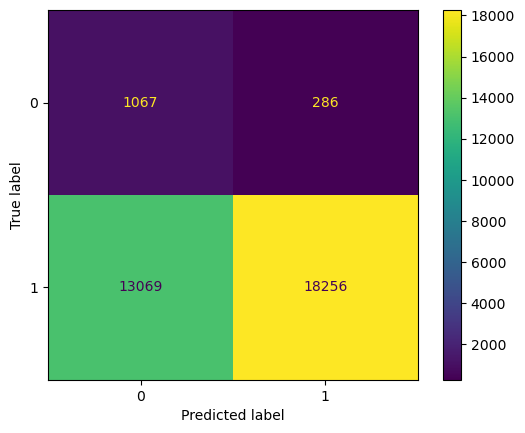

In [18]:
ros = RandomOverSampler(random_state=0)
X_resampled4, y_resampled4 = ros.fit_resample(X_train, y_train4)

myLogReg(X_resampled4, y_resampled4,X_test,y_test4)

Now, let's see what happens with different over sampling tecniques:

Classification report for the test set
              precision    recall  f1-score   support

         1.0       0.04      0.56      0.07       506
         2.0       0.09      0.45      0.16      1228
         3.0       0.17      0.13      0.15      4477
         4.0       0.46      0.16      0.24     12358
         5.0       0.61      0.49      0.54     14109

    accuracy                           0.32     32678
   macro avg       0.27      0.36      0.23     32678
weighted avg       0.46      0.32      0.35     32678

Classification report for the train set
              precision    recall  f1-score   support

         1.0       0.34      0.55      0.42     56374
         2.0       0.33      0.43      0.37     56374
         3.0       0.26      0.13      0.18     56374
         4.0       0.34      0.16      0.22     56374
         5.0       0.45      0.49      0.47     56374

    accuracy                           0.35    281870
   macro avg       0.34      0.35      0.33    28187

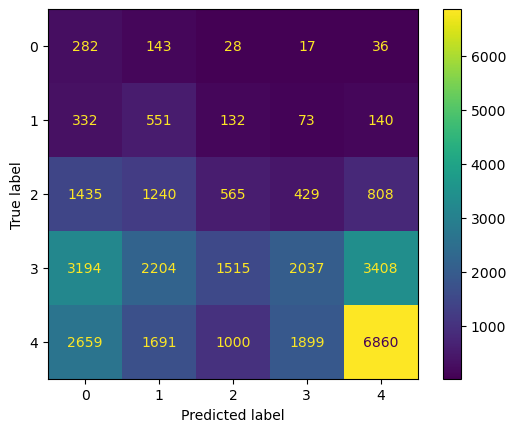

In [19]:
X_resampled1, y_resampled1 = SMOTE().fit_resample(X_train, y_train1)

myLogReg(X_resampled1, y_resampled1,X_test,y_test1)

Classification report for the test set
              precision    recall  f1-score   support

         1.0       0.34      0.48      0.40      6536
         2.0       0.28      0.24      0.26      6536
         3.0       0.25      0.07      0.10      6535
         4.0       0.34      0.36      0.35      6536
         5.0       0.40      0.57      0.47      6535

    accuracy                           0.34     32678
   macro avg       0.32      0.34      0.32     32678
weighted avg       0.32      0.34      0.32     32678

Classification report for the train set
              precision    recall  f1-score   support

         1.0       0.35      0.48      0.41     26142
         2.0       0.28      0.24      0.26     26142
         3.0       0.25      0.06      0.10     26142
         4.0       0.33      0.35      0.34     26142
         5.0       0.39      0.57      0.46     26142

    accuracy                           0.34    130710
   macro avg       0.32      0.34      0.31    13071

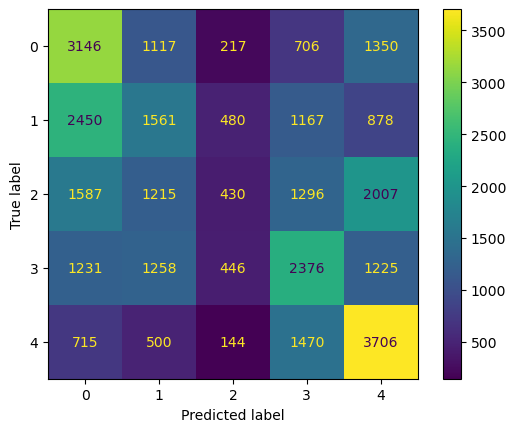

In [20]:
X_resampled2, y_resampled2 = SMOTE().fit_resample(X_train, y_train2)

myLogReg(X_resampled2, y_resampled2,X_test,y_test2)

Classification report for the test set
              precision    recall  f1-score   support

         1.0       0.46      0.51      0.48      9429
         2.0       0.27      0.17      0.21      6697
         3.0       0.21      0.08      0.11      6048
         4.0       0.32      0.42      0.37      5503
         5.0       0.39      0.68      0.49      5001

    accuracy                           0.37     32678
   macro avg       0.33      0.37      0.33     32678
weighted avg       0.34      0.37      0.34     32678

Classification report for the train set
              precision    recall  f1-score   support

         1.0       0.36      0.51      0.42     37801
         2.0       0.28      0.17      0.21     37801
         3.0       0.24      0.08      0.12     37801
         4.0       0.37      0.43      0.40     37801
         5.0       0.46      0.68      0.55     37801

    accuracy                           0.37    189005
   macro avg       0.34      0.37      0.34    18900

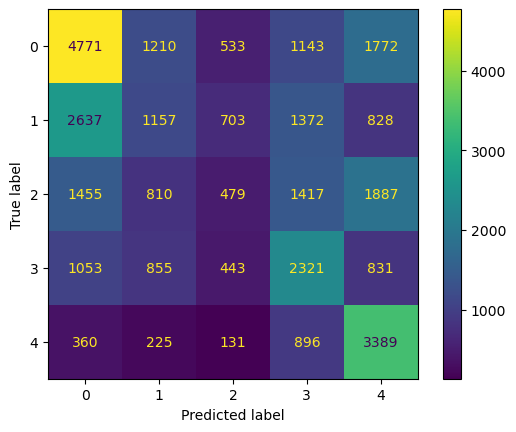

In [21]:
X_resampled3, y_resampled3 = SMOTE().fit_resample(X_train, y_train3)

myLogReg(X_resampled3, y_resampled3,X_test,y_test3)

Classification report for the test set
              precision    recall  f1-score   support

         1.0       0.08      0.78      0.14      1353
         2.0       0.98      0.59      0.74     31325

    accuracy                           0.60     32678
   macro avg       0.53      0.69      0.44     32678
weighted avg       0.95      0.60      0.71     32678

Classification report for the train set
              precision    recall  f1-score   support

         1.0       0.66      0.80      0.73    125061
         2.0       0.75      0.59      0.66    125061

    accuracy                           0.70    250122
   macro avg       0.71      0.70      0.69    250122
weighted avg       0.71      0.70      0.69    250122



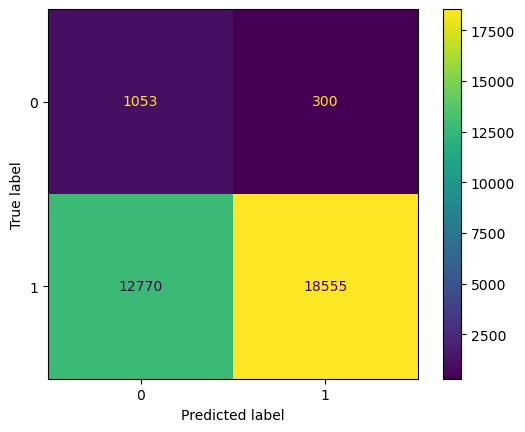

In [22]:
X_resampled4, y_resampled4 = SMOTE().fit_resample(X_train, y_train4)

myLogReg(X_resampled4, y_resampled4,X_test,y_test4)

In [23]:
poly = PolynomialFeatures(2)
X_trainPoly=poly.fit_transform(X_train)
X_testPoly=poly.fit_transform(X_test)


Classification report for the test set
              precision    recall  f1-score   support

         1.0       0.37      0.07      0.11       506
         2.0       0.18      0.01      0.02      1228
         3.0       0.27      0.02      0.04      4477
         4.0       0.47      0.58      0.52     12358
         5.0       0.58      0.69      0.63     14109

    accuracy                           0.52     32678
   macro avg       0.37      0.27      0.26     32678
weighted avg       0.47      0.52      0.47     32678

Classification report for the train set
              precision    recall  f1-score   support

         1.0       0.43      0.07      0.11      2033
         2.0       0.43      0.02      0.04      5107
         3.0       0.40      0.03      0.06     18013
         4.0       0.47      0.59      0.52     49182
         5.0       0.58      0.70      0.63     56374

    accuracy                           0.53    130709
   macro avg       0.46      0.28      0.27    13070

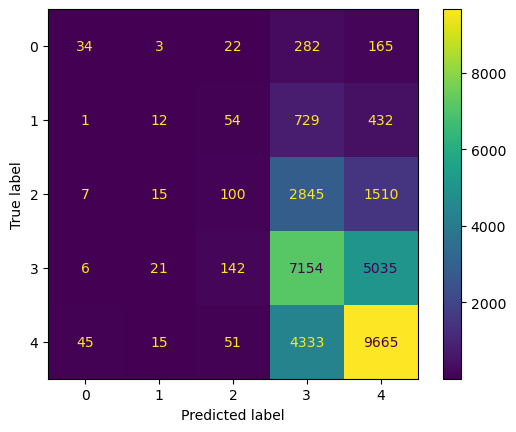

In [51]:
myLogReg(X_trainPoly, y_train1,X_testPoly,y_test1)

Classification report for the test set
              precision    recall  f1-score   support

         1.0       0.38      0.46      0.42      6536
         2.0       0.31      0.36      0.33      6536
         3.0       0.26      0.05      0.09      6535
         4.0       0.35      0.44      0.39      6536
         5.0       0.49      0.57      0.53      6535

    accuracy                           0.38     32678
   macro avg       0.36      0.38      0.35     32678
weighted avg       0.36      0.38      0.35     32678

Classification report for the train set
              precision    recall  f1-score   support

         1.0       0.40      0.48      0.43     26142
         2.0       0.33      0.37      0.35     26142
         3.0       0.28      0.06      0.10     26142
         4.0       0.36      0.44      0.39     26142
         5.0       0.50      0.58      0.53     26141

    accuracy                           0.39    130709
   macro avg       0.37      0.39      0.36    13070

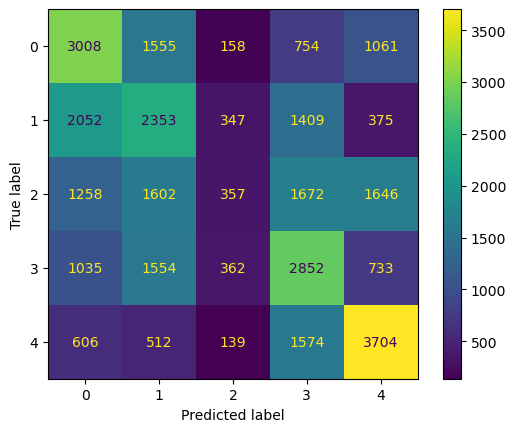

In [52]:
myLogReg(X_trainPoly, y_train2,X_testPoly,y_test2)

Classification report for the test set
              precision    recall  f1-score   support

         1.0       0.43      0.71      0.53      9429
         2.0       0.31      0.19      0.24      6697
         3.0       0.24      0.05      0.08      6048
         4.0       0.36      0.38      0.37      5503
         5.0       0.53      0.62      0.57      5001

    accuracy                           0.41     32678
   macro avg       0.37      0.39      0.36     32678
weighted avg       0.37      0.41      0.37     32678

Classification report for the train set
              precision    recall  f1-score   support

         1.0       0.44      0.72      0.54     37801
         2.0       0.32      0.20      0.25     26790
         3.0       0.28      0.06      0.09     24167
         4.0       0.38      0.40      0.39     21973
         5.0       0.53      0.63      0.58     19978

    accuracy                           0.42    130709
   macro avg       0.39      0.40      0.37    13070

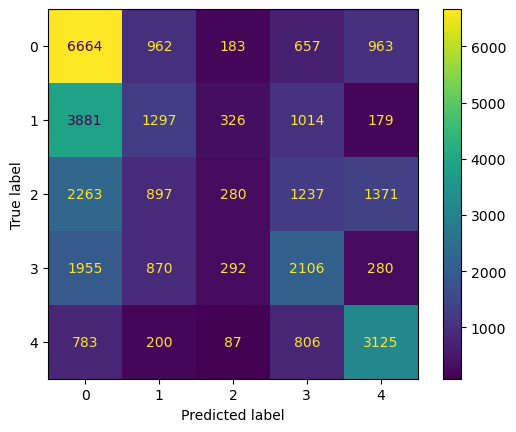

In [53]:
myLogReg(X_trainPoly, y_train3,X_testPoly,y_test3)

Classification report for the test set
              precision    recall  f1-score   support

         1.0       0.25      0.01      0.01      1353
         2.0       0.96      1.00      0.98     31325

    accuracy                           0.96     32678
   macro avg       0.60      0.50      0.50     32678
weighted avg       0.93      0.96      0.94     32678

Classification report for the train set
              precision    recall  f1-score   support

         1.0       0.39      0.01      0.02      5648
         2.0       0.96      1.00      0.98    125061

    accuracy                           0.96    130709
   macro avg       0.67      0.50      0.50    130709
weighted avg       0.93      0.96      0.94    130709



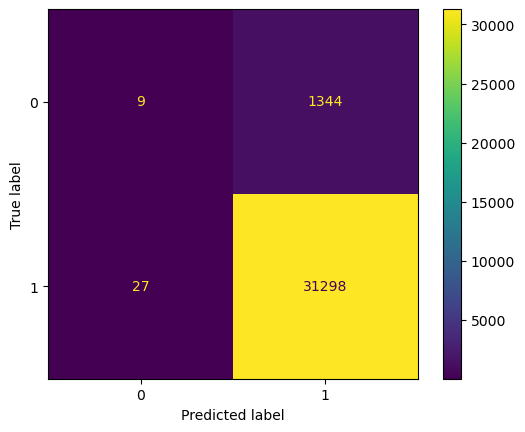

In [54]:
myLogReg(X_trainPoly, y_train4,X_testPoly,y_test4)

/home/tolatale/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification report for the test set
              precision    recall  f1-score   support

         1.0       0.05      0.52      0.10       506
         2.0       0.09      0.45      0.15      1228
         3.0       0.20      0.17      0.18      4477
         4.0       0.50      0.27      0.35     12358
         5.0       0.64      0.50      0.56     14109

    accuracy                           0.37     32678
   macro avg       0.30      0.38      0.27     32678
weighted avg       0.50      0.37      0.41     32678

Classification report for the train set
              precision    recall  f1-score   support

         1.0       0.46      0.57      0.51     56374
         2.0       0.37      0.53      0.43     56374
         3.0       0.34      0.20      0.26     56374
         4.0       0.41      0.28      0.33     56374
         5.0       0.50      0.51      0.50     56374

    accuracy                           0.42    281870
   macro avg       0.42      0.42      0.41    28187

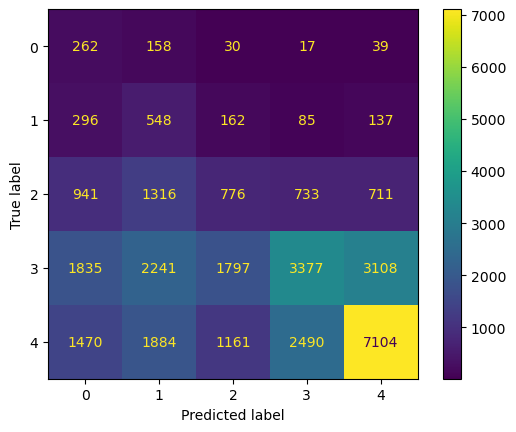

In [55]:
X_resampled1, y_resampled1 = SMOTE().fit_resample(X_trainPoly, y_train1)

myLogReg(X_resampled1, y_resampled1,X_testPoly,y_test1)

Classification report for the test set
              precision    recall  f1-score   support

         1.0       0.38      0.46      0.41      6536
         2.0       0.31      0.36      0.33      6536
         3.0       0.26      0.05      0.09      6535
         4.0       0.35      0.44      0.39      6536
         5.0       0.49      0.57      0.53      6535

    accuracy                           0.38     32678
   macro avg       0.36      0.38      0.35     32678
weighted avg       0.36      0.38      0.35     32678

Classification report for the train set
              precision    recall  f1-score   support

         1.0       0.40      0.48      0.43     26142
         2.0       0.33      0.37      0.35     26142
         3.0       0.28      0.06      0.10     26142
         4.0       0.36      0.44      0.39     26142
         5.0       0.50      0.58      0.53     26142

    accuracy                           0.39    130710
   macro avg       0.37      0.39      0.36    13071

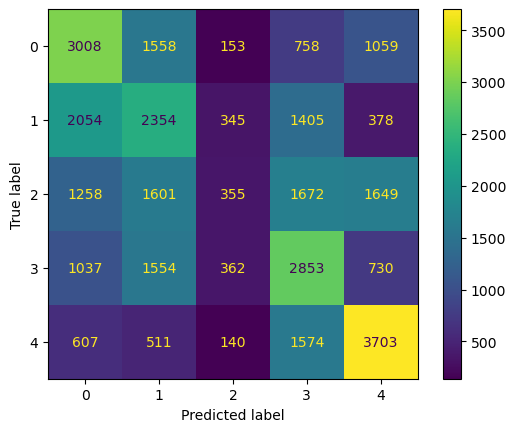

In [56]:
X_resampled2, y_resampled2 = SMOTE().fit_resample(X_trainPoly, y_train2)

myLogReg(X_resampled2, y_resampled2,X_testPoly,y_test2)

Classification report for the test set
              precision    recall  f1-score   support

         1.0       0.50      0.51      0.50      9429
         2.0       0.31      0.31      0.31      6697
         3.0       0.23      0.06      0.09      6048
         4.0       0.33      0.48      0.39      5503
         5.0       0.49      0.67      0.56      5001

    accuracy                           0.40     32678
   macro avg       0.37      0.41      0.37     32678
weighted avg       0.38      0.40      0.38     32678

Classification report for the train set
              precision    recall  f1-score   support

         1.0       0.40      0.52      0.45     37801
         2.0       0.33      0.32      0.32     37801
         3.0       0.29      0.07      0.11     37801
         4.0       0.38      0.50      0.44     37801
         5.0       0.57      0.68      0.62     37801

    accuracy                           0.42    189005
   macro avg       0.39      0.42      0.39    18900

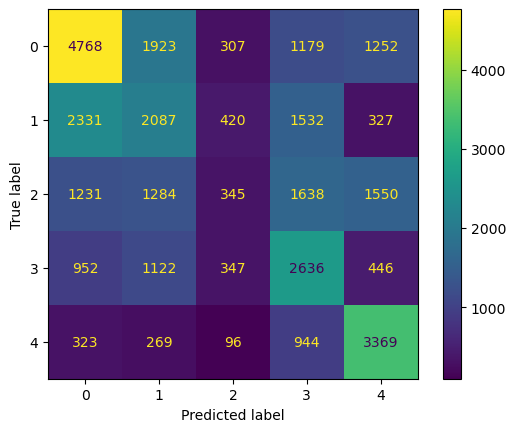

In [57]:
X_resampled3, y_resampled3 = SMOTE().fit_resample(X_trainPoly, y_train3)

myLogReg(X_resampled3, y_resampled3,X_testPoly,y_test3)

Classification report for the test set
              precision    recall  f1-score   support

         1.0       0.10      0.78      0.17      1353
         2.0       0.99      0.69      0.81     31325

    accuracy                           0.69     32678
   macro avg       0.54      0.73      0.49     32678
weighted avg       0.95      0.69      0.78     32678

Classification report for the train set
              precision    recall  f1-score   support

         1.0       0.73      0.86      0.79    125061
         2.0       0.83      0.69      0.75    125061

    accuracy                           0.77    250122
   macro avg       0.78      0.77      0.77    250122
weighted avg       0.78      0.77      0.77    250122



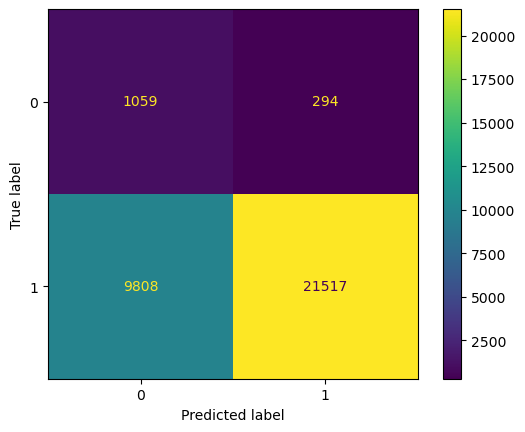

In [24]:
X_resampled4, y_resampled4 = SMOTE().fit_resample(X_trainPoly, y_train4)

myLogReg(X_resampled4, y_resampled4,X_testPoly,y_test4)

TRAIN WITH INITIAL DISTRIBUTION GRID SEARCH
result: useless

In [35]:
solvers = ['newton-cg', 'lbfgs', 'saga','sag','liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]

# summarize results
for solver in solvers:
    for pen in penalty:
        for value in c_values:
            lrm = skm.LogisticRegression(multi_class='multinomial',max_iter=10000,random_state=2,solver=solver,
                                         penalty=pen,C=value)
            print("-------------------------------------------")
            lrm.fit(X_train,y_train1)
            preds=lrm.predict(X_test)
            check=preds==y_test1
            print("solver=",solver,"penalty=",pen,"value=",value)
            accuracy = accuracy_score(y_test1, preds)
            print("Accuracy:", accuracy)
            print(classification_report(y_test1, preds))

            preds_train=lrm.predict(X_train)
            check=preds_train==y_train1
            accuracy = accuracy_score(y_train1, preds_train)
            print("Accuracy training:", accuracy)
            print(classification_report(y_train1, preds_train))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    
    print("%f (%f) with: %r" % (mean, stdev, param))

-------------------------------------------


KeyboardInterrupt: 

HYPOTHESIS FOR USEFUL FEATURES:

-assessment_type

-highest education

-weight













IDEAS

show a map of most influential features compared to grades